In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from pathlib import Path
import pandas as pd
import numpy as np

from utils import (cross_validate_hyperparameters, train_model, test_model,
                   show_random_images, plot_class_distribution,)
from cnn_model import BasicCNN, DeepCNN, ResNet, EnsembleModel

# 设置设备
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

# 创建模型和结果保存目录
Path("../model").mkdir(parents=True, exist_ok=True)
Path("../result").mkdir(parents=True, exist_ok=True)

Using device: mps


In [2]:
# 超参数
batch_size = 128
num_epochs = 50

In [3]:
# 数据增强和预处理
transforms_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载CIFAR-10数据集
train_dataset = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True, transform=transforms_train)
test_dataset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True, transform=transforms_test)

# 分离出验证集
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# 数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# CIFAR-10 类别
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

显示训练集样本:


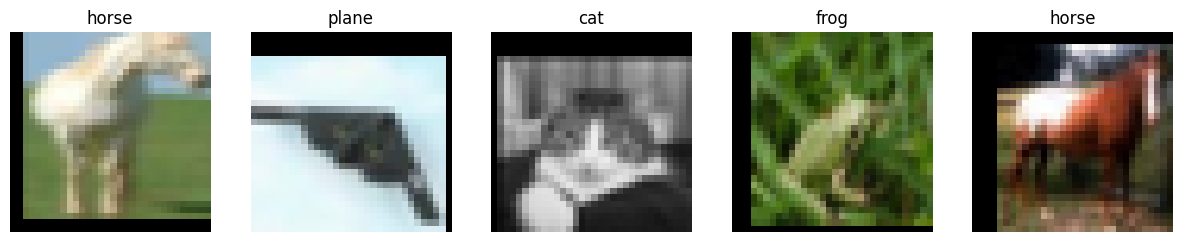

训练集类别分布:


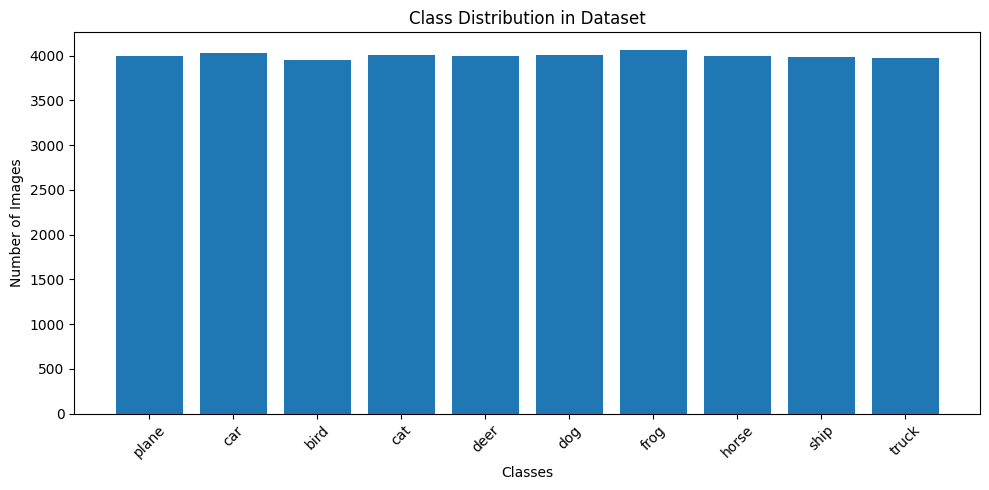

In [4]:
# 显示一些随机样本
print("显示训练集样本:")
show_random_images(train_dataset, classes)

# 显示类别分布
print("训练集类别分布:")
plot_class_distribution(train_dataset, classes)

In [5]:
# 交叉验证寻找最佳超参数
print("\n===== 开始交叉验证 =====")
cv_params = {
    'dropout_rate': [0.2, 0.5],
    'normalization': ['batch', 'instance', 'layer', 'group', 'none'],
    'num_filters_1': [32],
    'num_filters_2': [64]
}

# 使用小型数据集进行交叉验证以节省时间
cv_subset = torch.utils.data.Subset(
    train_dataset,
    indices=np.random.choice(len(train_dataset), size=int(len(train_dataset) * 0.2), replace=False)
)

best_params = cross_validate_hyperparameters(
    BasicCNN,
    cv_params,
    cv_subset,
    num_folds=3,
    batch_size=64,
    num_epochs=3,
    device=device
)


===== 开始交叉验证 =====
Testing hyperparameters: {'dropout_rate': 0.2, 'normalization': 'batch', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 46.30it/s]


    Epoch 1: Validation Accuracy = 32.62%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 72.17it/s]


    Epoch 2: Validation Accuracy = 41.51%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 65.39it/s]


    Epoch 3: Validation Accuracy = 44.73%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 74.91it/s]


    Epoch 1: Validation Accuracy = 34.57%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 53.37it/s]


    Epoch 2: Validation Accuracy = 40.87%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 74.56it/s]


    Epoch 3: Validation Accuracy = 44.21%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 47.30it/s]


    Epoch 1: Validation Accuracy = 35.18%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 76.25it/s]


    Epoch 2: Validation Accuracy = 39.50%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 73.97it/s]


    Epoch 3: Validation Accuracy = 42.87%
  Average validation accuracy: 43.94%
Testing hyperparameters: {'dropout_rate': 0.2, 'normalization': 'instance', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 81.62it/s]


    Epoch 1: Validation Accuracy = 24.45%


Epoch 2/3: 100%|██████████| 84/84 [00:00<00:00, 87.99it/s]


    Epoch 2: Validation Accuracy = 31.68%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 63.83it/s]


    Epoch 3: Validation Accuracy = 36.86%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:00<00:00, 87.52it/s]


    Epoch 1: Validation Accuracy = 31.61%


Epoch 2/3: 100%|██████████| 84/84 [00:00<00:00, 84.15it/s]


    Epoch 2: Validation Accuracy = 37.95%


Epoch 3/3: 100%|██████████| 84/84 [00:00<00:00, 85.49it/s]


    Epoch 3: Validation Accuracy = 36.33%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 76.73it/s]


    Epoch 1: Validation Accuracy = 26.78%


Epoch 2/3: 100%|██████████| 84/84 [00:00<00:00, 89.25it/s]


    Epoch 2: Validation Accuracy = 34.70%


Epoch 3/3: 100%|██████████| 84/84 [00:00<00:00, 93.51it/s]


    Epoch 3: Validation Accuracy = 38.82%
  Average validation accuracy: 37.88%
Testing hyperparameters: {'dropout_rate': 0.2, 'normalization': 'layer', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 59.03it/s]


    Epoch 1: Validation Accuracy = 31.38%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 45.31it/s]


    Epoch 2: Validation Accuracy = 37.23%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 58.88it/s]


    Epoch 3: Validation Accuracy = 41.02%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 62.91it/s]


    Epoch 1: Validation Accuracy = 29.47%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 49.39it/s]


    Epoch 2: Validation Accuracy = 37.65%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 71.27it/s]


    Epoch 3: Validation Accuracy = 41.62%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 47.36it/s]


    Epoch 1: Validation Accuracy = 27.98%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 65.38it/s]


    Epoch 2: Validation Accuracy = 34.96%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 60.16it/s]


    Epoch 3: Validation Accuracy = 37.13%
  Average validation accuracy: 39.92%
Testing hyperparameters: {'dropout_rate': 0.2, 'normalization': 'group', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 58.70it/s]


    Epoch 1: Validation Accuracy = 27.22%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 43.40it/s]


    Epoch 2: Validation Accuracy = 37.87%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 58.22it/s]


    Epoch 3: Validation Accuracy = 38.73%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 44.05it/s]


    Epoch 1: Validation Accuracy = 31.65%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 57.84it/s]


    Epoch 2: Validation Accuracy = 33.75%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 62.59it/s]


    Epoch 3: Validation Accuracy = 40.16%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 61.22it/s]


    Epoch 1: Validation Accuracy = 32.48%


Epoch 2/3: 100%|██████████| 84/84 [00:02<00:00, 40.70it/s]


    Epoch 2: Validation Accuracy = 34.47%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 47.28it/s]


    Epoch 3: Validation Accuracy = 40.06%
  Average validation accuracy: 39.65%
Testing hyperparameters: {'dropout_rate': 0.2, 'normalization': 'none', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:00<00:00, 91.00it/s]


    Epoch 1: Validation Accuracy = 32.85%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 67.43it/s]


    Epoch 2: Validation Accuracy = 40.12%


Epoch 3/3: 100%|██████████| 84/84 [00:00<00:00, 88.82it/s]


    Epoch 3: Validation Accuracy = 41.58%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:00<00:00, 98.79it/s]


    Epoch 1: Validation Accuracy = 32.47%


Epoch 2/3: 100%|██████████| 84/84 [00:00<00:00, 87.11it/s]


    Epoch 2: Validation Accuracy = 41.09%


Epoch 3/3: 100%|██████████| 84/84 [00:00<00:00, 96.85it/s]


    Epoch 3: Validation Accuracy = 39.00%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:00<00:00, 92.65it/s]


    Epoch 1: Validation Accuracy = 31.70%


Epoch 2/3: 100%|██████████| 84/84 [00:00<00:00, 93.30it/s] 


    Epoch 2: Validation Accuracy = 37.47%


Epoch 3/3: 100%|██████████| 84/84 [00:00<00:00, 101.64it/s]


    Epoch 3: Validation Accuracy = 41.52%
  Average validation accuracy: 41.40%
Testing hyperparameters: {'dropout_rate': 0.5, 'normalization': 'batch', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:00<00:00, 85.78it/s]


    Epoch 1: Validation Accuracy = 31.68%


Epoch 2/3: 100%|██████████| 84/84 [00:00<00:00, 85.51it/s]


    Epoch 2: Validation Accuracy = 38.43%


Epoch 3/3: 100%|██████████| 84/84 [00:00<00:00, 89.34it/s]


    Epoch 3: Validation Accuracy = 38.81%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 83.91it/s]


    Epoch 1: Validation Accuracy = 33.00%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 83.10it/s]


    Epoch 2: Validation Accuracy = 33.97%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 75.21it/s]


    Epoch 3: Validation Accuracy = 39.71%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 83.10it/s]


    Epoch 1: Validation Accuracy = 30.35%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 58.39it/s]


    Epoch 2: Validation Accuracy = 34.40%


Epoch 3/3: 100%|██████████| 84/84 [00:00<00:00, 88.78it/s]


    Epoch 3: Validation Accuracy = 36.98%
  Average validation accuracy: 38.50%
Testing hyperparameters: {'dropout_rate': 0.5, 'normalization': 'instance', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 82.10it/s]


    Epoch 1: Validation Accuracy = 20.55%


Epoch 2/3: 100%|██████████| 84/84 [00:00<00:00, 103.78it/s]


    Epoch 2: Validation Accuracy = 21.90%


Epoch 3/3: 100%|██████████| 84/84 [00:00<00:00, 98.49it/s]


    Epoch 3: Validation Accuracy = 27.97%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:00<00:00, 94.81it/s]


    Epoch 1: Validation Accuracy = 26.66%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 83.73it/s]


    Epoch 2: Validation Accuracy = 32.32%


Epoch 3/3: 100%|██████████| 84/84 [00:00<00:00, 95.79it/s]


    Epoch 3: Validation Accuracy = 33.33%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:00<00:00, 98.04it/s]


    Epoch 1: Validation Accuracy = 20.03%


Epoch 2/3: 100%|██████████| 84/84 [00:00<00:00, 99.68it/s] 


    Epoch 2: Validation Accuracy = 23.26%


Epoch 3/3: 100%|██████████| 84/84 [00:00<00:00, 97.15it/s]


    Epoch 3: Validation Accuracy = 23.07%
  Average validation accuracy: 28.19%
Testing hyperparameters: {'dropout_rate': 0.5, 'normalization': 'layer', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 58.25it/s]


    Epoch 1: Validation Accuracy = 26.28%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 51.41it/s]


    Epoch 2: Validation Accuracy = 34.38%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 73.87it/s]


    Epoch 3: Validation Accuracy = 36.11%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 70.63it/s]


    Epoch 1: Validation Accuracy = 22.42%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 72.74it/s]


    Epoch 2: Validation Accuracy = 28.31%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 74.31it/s]


    Epoch 3: Validation Accuracy = 30.86%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 74.61it/s]


    Epoch 1: Validation Accuracy = 27.27%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 54.34it/s]


    Epoch 2: Validation Accuracy = 32.18%


Epoch 3/3: 100%|██████████| 84/84 [00:02<00:00, 40.15it/s]


    Epoch 3: Validation Accuracy = 36.12%
  Average validation accuracy: 34.36%
Testing hyperparameters: {'dropout_rate': 0.5, 'normalization': 'group', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 62.13it/s]


    Epoch 1: Validation Accuracy = 28.16%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 51.07it/s]


    Epoch 2: Validation Accuracy = 30.63%


Epoch 3/3: 100%|██████████| 84/84 [00:02<00:00, 36.69it/s]


    Epoch 3: Validation Accuracy = 36.93%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 50.24it/s]


    Epoch 1: Validation Accuracy = 27.67%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 56.30it/s]


    Epoch 2: Validation Accuracy = 32.21%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 59.91it/s]


    Epoch 3: Validation Accuracy = 35.25%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:01<00:00, 47.60it/s]


    Epoch 1: Validation Accuracy = 22.84%


Epoch 2/3: 100%|██████████| 84/84 [00:02<00:00, 37.68it/s]


    Epoch 2: Validation Accuracy = 28.88%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 60.42it/s]


    Epoch 3: Validation Accuracy = 29.97%
  Average validation accuracy: 34.05%
Testing hyperparameters: {'dropout_rate': 0.5, 'normalization': 'none', 'num_filters_1': 32, 'num_filters_2': 64}
  Fold 1/3


Epoch 1/3: 100%|██████████| 84/84 [00:00<00:00, 88.88it/s]


    Epoch 1: Validation Accuracy = 27.71%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 69.64it/s]


    Epoch 2: Validation Accuracy = 35.88%


Epoch 3/3: 100%|██████████| 84/84 [00:00<00:00, 86.95it/s]


    Epoch 3: Validation Accuracy = 40.53%
  Fold 2/3


Epoch 1/3: 100%|██████████| 84/84 [00:00<00:00, 89.64it/s]


    Epoch 1: Validation Accuracy = 30.26%


Epoch 2/3: 100%|██████████| 84/84 [00:00<00:00, 92.66it/s]


    Epoch 2: Validation Accuracy = 35.40%


Epoch 3/3: 100%|██████████| 84/84 [00:00<00:00, 94.02it/s]


    Epoch 3: Validation Accuracy = 40.12%
  Fold 3/3


Epoch 1/3: 100%|██████████| 84/84 [00:00<00:00, 89.29it/s]


    Epoch 1: Validation Accuracy = 29.56%


Epoch 2/3: 100%|██████████| 84/84 [00:01<00:00, 71.58it/s]


    Epoch 2: Validation Accuracy = 35.52%


Epoch 3/3: 100%|██████████| 84/84 [00:01<00:00, 82.72it/s]


    Epoch 3: Validation Accuracy = 39.08%
  Average validation accuracy: 39.91%

===== Cross-Validation Results =====
Parameters: {'dropout_rate': 0.2, 'normalization': 'batch', 'num_filters_1': 32, 'num_filters_2': 64}
  Average accuracy: 43.94%
  Fold accuracies: [44.73190851143607, 44.20697412823397, 42.87321830457614]
Parameters: {'dropout_rate': 0.2, 'normalization': 'none', 'num_filters_1': 32, 'num_filters_2': 64}
  Average accuracy: 41.40%
  Fold accuracies: [41.582302212223475, 41.094863142107236, 41.52288072018005]
Parameters: {'dropout_rate': 0.2, 'normalization': 'layer', 'num_filters_1': 32, 'num_filters_2': 64}
  Average accuracy: 39.92%
  Fold accuracies: [41.01987251593551, 41.61979752530934, 37.13428357089272]
Parameters: {'dropout_rate': 0.5, 'normalization': 'none', 'num_filters_1': 32, 'num_filters_2': 64}
  Average accuracy: 39.91%
  Fold accuracies: [40.53243344581927, 40.11998500187477, 39.0847711927982]
Parameters: {'dropout_rate': 0.2, 'normalization': 'group',

In [6]:
# 使用最佳参数训练模型
print("\n===== 使用最佳参数训练模型 =====")
model_cnn = BasicCNN(**best_params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

history_cnn = train_model(
    model_cnn,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    'BasicCNN_BestParams',
    scheduler
)


===== 使用最佳参数训练模型 =====


Epoch 1/50: 100%|██████████| 313/313 [00:20<00:00, 15.15it/s, loss: 1.6673 - acc: 38.42%]


Epoch 1/50 - loss: 1.6673 - acc: 38.42% - val_loss: 1.4165 - val_acc: 47.98% - test_acc: 53.04%


Epoch 2/50: 100%|██████████| 313/313 [00:20<00:00, 15.38it/s, loss: 1.3814 - acc: 49.58%]


Epoch 2/50 - loss: 1.3814 - acc: 49.58% - val_loss: 1.2489 - val_acc: 55.03% - test_acc: 58.66%


Epoch 3/50: 100%|██████████| 313/313 [00:20<00:00, 15.56it/s, loss: 1.2732 - acc: 53.87%]


Epoch 3/50 - loss: 1.2732 - acc: 53.87% - val_loss: 1.2284 - val_acc: 55.85% - test_acc: 60.51%


Epoch 4/50: 100%|██████████| 313/313 [00:20<00:00, 15.35it/s, loss: 1.2042 - acc: 56.69%]


Epoch 4/50 - loss: 1.2042 - acc: 56.69% - val_loss: 1.2025 - val_acc: 57.29% - test_acc: 61.28%


Epoch 5/50: 100%|██████████| 313/313 [00:20<00:00, 15.53it/s, loss: 1.1585 - acc: 58.88%]


Epoch 5/50 - loss: 1.1585 - acc: 58.88% - val_loss: 1.0731 - val_acc: 61.66% - test_acc: 65.64%


Epoch 6/50: 100%|██████████| 313/313 [00:20<00:00, 15.19it/s, loss: 1.1340 - acc: 59.66%]


Epoch 6/50 - loss: 1.1340 - acc: 59.66% - val_loss: 1.0412 - val_acc: 62.90% - test_acc: 67.50%


Epoch 7/50: 100%|██████████| 313/313 [00:20<00:00, 15.35it/s, loss: 1.1015 - acc: 60.61%]


Epoch 7/50 - loss: 1.1015 - acc: 60.61% - val_loss: 1.0211 - val_acc: 63.52% - test_acc: 68.48%


Epoch 8/50: 100%|██████████| 313/313 [00:19<00:00, 15.71it/s, loss: 1.0731 - acc: 61.66%]


Epoch 8/50 - loss: 1.0731 - acc: 61.66% - val_loss: 1.0027 - val_acc: 64.77% - test_acc: 68.95%


Epoch 9/50: 100%|██████████| 313/313 [00:22<00:00, 13.69it/s, loss: 1.0410 - acc: 63.27%]


Epoch 9/50 - loss: 1.0410 - acc: 63.27% - val_loss: 0.9631 - val_acc: 65.42% - test_acc: 68.55%


Epoch 10/50: 100%|██████████| 313/313 [00:19<00:00, 16.14it/s, loss: 1.0284 - acc: 63.61%]


Epoch 10/50 - loss: 1.0284 - acc: 63.61% - val_loss: 0.9794 - val_acc: 65.81% - test_acc: 70.02%


Epoch 11/50: 100%|██████████| 313/313 [00:20<00:00, 15.40it/s, loss: 1.0112 - acc: 64.31%]


Epoch 11/50 - loss: 1.0112 - acc: 64.31% - val_loss: 0.9377 - val_acc: 66.87% - test_acc: 70.79%


Epoch 12/50: 100%|██████████| 313/313 [00:19<00:00, 16.33it/s, loss: 0.9938 - acc: 64.57%]


Epoch 12/50 - loss: 0.9938 - acc: 64.57% - val_loss: 0.9147 - val_acc: 67.45% - test_acc: 70.51%


Epoch 13/50: 100%|██████████| 313/313 [00:20<00:00, 15.56it/s, loss: 0.9782 - acc: 65.42%]


Epoch 13/50 - loss: 0.9782 - acc: 65.42% - val_loss: 0.9513 - val_acc: 67.17% - test_acc: 70.06%


Epoch 14/50: 100%|██████████| 313/313 [00:20<00:00, 15.22it/s, loss: 0.9690 - acc: 65.46%]


Epoch 14/50 - loss: 0.9690 - acc: 65.46% - val_loss: 0.9117 - val_acc: 67.83% - test_acc: 71.79%


Epoch 15/50: 100%|██████████| 313/313 [00:22<00:00, 14.11it/s, loss: 0.9523 - acc: 66.16%]


Epoch 15/50 - loss: 0.9523 - acc: 66.16% - val_loss: 0.8862 - val_acc: 69.54% - test_acc: 72.27%


Epoch 16/50: 100%|██████████| 313/313 [00:22<00:00, 13.92it/s, loss: 0.9377 - acc: 66.69%]


Epoch 16/50 - loss: 0.9377 - acc: 66.69% - val_loss: 0.9151 - val_acc: 67.26% - test_acc: 72.09%


Epoch 17/50: 100%|██████████| 313/313 [00:19<00:00, 15.90it/s, loss: 0.9254 - acc: 67.31%]


Epoch 17/50 - loss: 0.9254 - acc: 67.31% - val_loss: 0.9290 - val_acc: 67.64% - test_acc: 70.58%


Epoch 18/50: 100%|██████████| 313/313 [00:20<00:00, 15.45it/s, loss: 0.9118 - acc: 67.81%]


Epoch 18/50 - loss: 0.9118 - acc: 67.81% - val_loss: 0.8685 - val_acc: 70.05% - test_acc: 72.58%


Epoch 19/50: 100%|██████████| 313/313 [00:19<00:00, 16.29it/s, loss: 0.9076 - acc: 68.13%]


Epoch 19/50 - loss: 0.9076 - acc: 68.13% - val_loss: 0.9041 - val_acc: 68.14% - test_acc: 71.78%


Epoch 20/50: 100%|██████████| 313/313 [00:19<00:00, 16.18it/s, loss: 0.9033 - acc: 68.34%]


Epoch 20/50 - loss: 0.9033 - acc: 68.34% - val_loss: 0.8252 - val_acc: 70.82% - test_acc: 74.16%


Epoch 21/50: 100%|██████████| 313/313 [00:27<00:00, 11.35it/s, loss: 0.8945 - acc: 68.44%]


Epoch 21/50 - loss: 0.8945 - acc: 68.44% - val_loss: 0.8355 - val_acc: 70.84% - test_acc: 74.31%


Epoch 22/50: 100%|██████████| 313/313 [00:22<00:00, 13.70it/s, loss: 0.8782 - acc: 69.00%]


Epoch 22/50 - loss: 0.8782 - acc: 69.00% - val_loss: 0.8313 - val_acc: 71.08% - test_acc: 73.57%


Epoch 23/50: 100%|██████████| 313/313 [00:22<00:00, 13.98it/s, loss: 0.8746 - acc: 69.23%]


Epoch 23/50 - loss: 0.8746 - acc: 69.23% - val_loss: 0.8420 - val_acc: 71.03% - test_acc: 73.42%


Epoch 24/50: 100%|██████████| 313/313 [00:21<00:00, 14.43it/s, loss: 0.8610 - acc: 69.64%]


Epoch 24/50 - loss: 0.8610 - acc: 69.64% - val_loss: 0.7989 - val_acc: 72.23% - test_acc: 75.74%


Epoch 25/50: 100%|██████████| 313/313 [00:21<00:00, 14.47it/s, loss: 0.8586 - acc: 69.72%]


Epoch 25/50 - loss: 0.8586 - acc: 69.72% - val_loss: 0.8104 - val_acc: 71.99% - test_acc: 74.21%


Epoch 26/50: 100%|██████████| 313/313 [00:22<00:00, 14.09it/s, loss: 0.8548 - acc: 69.82%]


Epoch 26/50 - loss: 0.8548 - acc: 69.82% - val_loss: 0.7974 - val_acc: 72.25% - test_acc: 75.43%


Epoch 27/50: 100%|██████████| 313/313 [00:21<00:00, 14.47it/s, loss: 0.8434 - acc: 70.02%]


Epoch 27/50 - loss: 0.8434 - acc: 70.02% - val_loss: 0.8224 - val_acc: 71.20% - test_acc: 73.99%


Epoch 28/50: 100%|██████████| 313/313 [00:20<00:00, 15.58it/s, loss: 0.8386 - acc: 70.54%]


Epoch 28/50 - loss: 0.8386 - acc: 70.54% - val_loss: 0.7809 - val_acc: 72.93% - test_acc: 75.62%


Epoch 29/50: 100%|██████████| 313/313 [00:20<00:00, 15.09it/s, loss: 0.8344 - acc: 70.70%]


Epoch 29/50 - loss: 0.8344 - acc: 70.70% - val_loss: 0.8127 - val_acc: 71.88% - test_acc: 74.29%


Epoch 30/50: 100%|██████████| 313/313 [00:20<00:00, 15.46it/s, loss: 0.8284 - acc: 71.01%]


Epoch 30/50 - loss: 0.8284 - acc: 71.01% - val_loss: 0.7962 - val_acc: 72.10% - test_acc: 75.76%


Epoch 31/50: 100%|██████████| 313/313 [00:23<00:00, 13.29it/s, loss: 0.8201 - acc: 71.10%]


Epoch 31/50 - loss: 0.8201 - acc: 71.10% - val_loss: 0.7997 - val_acc: 72.21% - test_acc: 74.95%


Epoch 32/50: 100%|██████████| 313/313 [00:20<00:00, 14.97it/s, loss: 0.8203 - acc: 71.12%]


Epoch 32/50 - loss: 0.8203 - acc: 71.12% - val_loss: 0.7649 - val_acc: 73.38% - test_acc: 76.52%


Epoch 33/50: 100%|██████████| 313/313 [00:19<00:00, 16.02it/s, loss: 0.8064 - acc: 71.69%]


Epoch 33/50 - loss: 0.8064 - acc: 71.69% - val_loss: 0.7803 - val_acc: 72.69% - test_acc: 76.52%


Epoch 34/50: 100%|██████████| 313/313 [00:19<00:00, 15.92it/s, loss: 0.8018 - acc: 71.83%]


Epoch 34/50 - loss: 0.8018 - acc: 71.83% - val_loss: 0.8137 - val_acc: 71.81% - test_acc: 75.00%


Epoch 35/50: 100%|██████████| 313/313 [00:20<00:00, 15.35it/s, loss: 0.7956 - acc: 71.87%]


Epoch 35/50 - loss: 0.7956 - acc: 71.87% - val_loss: 0.7557 - val_acc: 73.77% - test_acc: 76.16%


Epoch 36/50: 100%|██████████| 313/313 [00:21<00:00, 14.57it/s, loss: 0.8010 - acc: 71.81%]


Epoch 36/50 - loss: 0.8010 - acc: 71.81% - val_loss: 0.7637 - val_acc: 73.27% - test_acc: 75.66%


Epoch 37/50: 100%|██████████| 313/313 [00:21<00:00, 14.47it/s, loss: 0.7897 - acc: 72.13%]


Epoch 37/50 - loss: 0.7897 - acc: 72.13% - val_loss: 0.8004 - val_acc: 72.59% - test_acc: 75.60%


Epoch 38/50: 100%|██████████| 313/313 [00:19<00:00, 15.78it/s, loss: 0.7866 - acc: 72.25%]


Epoch 38/50 - loss: 0.7866 - acc: 72.25% - val_loss: 0.7521 - val_acc: 73.64% - test_acc: 76.74%


Epoch 39/50: 100%|██████████| 313/313 [00:21<00:00, 14.74it/s, loss: 0.7799 - acc: 72.58%]


Epoch 39/50 - loss: 0.7799 - acc: 72.58% - val_loss: 0.7317 - val_acc: 74.68% - test_acc: 76.76%


Epoch 40/50: 100%|██████████| 313/313 [00:20<00:00, 15.08it/s, loss: 0.7782 - acc: 72.83%]


Epoch 40/50 - loss: 0.7782 - acc: 72.83% - val_loss: 0.7247 - val_acc: 74.97% - test_acc: 77.43%


Epoch 41/50: 100%|██████████| 313/313 [00:19<00:00, 16.01it/s, loss: 0.7741 - acc: 72.86%]


Epoch 41/50 - loss: 0.7741 - acc: 72.86% - val_loss: 0.7297 - val_acc: 74.99% - test_acc: 77.11%


Epoch 42/50: 100%|██████████| 313/313 [00:21<00:00, 14.41it/s, loss: 0.7819 - acc: 72.54%]


Epoch 42/50 - loss: 0.7819 - acc: 72.54% - val_loss: 0.7801 - val_acc: 73.31% - test_acc: 75.69%


Epoch 43/50: 100%|██████████| 313/313 [00:21<00:00, 14.28it/s, loss: 0.7674 - acc: 73.12%]


Epoch 43/50 - loss: 0.7674 - acc: 73.12% - val_loss: 0.7687 - val_acc: 73.34% - test_acc: 76.41%


Epoch 44/50: 100%|██████████| 313/313 [00:26<00:00, 11.88it/s, loss: 0.7663 - acc: 73.14%]


Epoch 44/50 - loss: 0.7663 - acc: 73.14% - val_loss: 0.7538 - val_acc: 73.53% - test_acc: 76.64%


Epoch 45/50: 100%|██████████| 313/313 [00:28<00:00, 10.94it/s, loss: 0.7580 - acc: 73.41%]


Epoch 45/50 - loss: 0.7580 - acc: 73.41% - val_loss: 0.7385 - val_acc: 74.88% - test_acc: 77.86%


Epoch 46/50: 100%|██████████| 313/313 [00:20<00:00, 15.51it/s, loss: 0.7506 - acc: 73.77%]


Epoch 46/50 - loss: 0.7506 - acc: 73.77% - val_loss: 0.7229 - val_acc: 75.12% - test_acc: 77.39%


Epoch 47/50: 100%|██████████| 313/313 [00:20<00:00, 15.01it/s, loss: 0.7514 - acc: 73.56%]


KeyboardInterrupt: 

In [ ]:
# 训练更深层的CNN模型
print("\n===== 训练深层CNN模型 =====")
model_deep = DeepCNN(
    dropout_rate=best_params['dropout_rate'],
    normalization=best_params['normalization']
).to(device)
optimizer = optim.Adam(model_deep.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

history_deep = train_model(
    model_deep,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    'DeepCNN',
    scheduler
)

In [ ]:
# 训练ResNet模型
print("\n===== 训练ResNet模型 =====")
model_resnet = ResNet(
    dropout_rate=best_params['dropout_rate'],
    normalization=best_params['normalization']
).to(device)
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

history_resnet = train_model(
    model_resnet,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    'ResNet',
    scheduler
)

In [ ]:
# 创建集成模型
print("\n===== 创建和评估模型集成 =====")

# 加载每个模型的最佳权重
model_cnn.load_state_dict(torch.load(f"../model/BasicCNN_BestParams/best_model.pth"))
model_deep.load_state_dict(torch.load(f"../model/DeepCNN/best_model.pth"))
model_resnet.load_state_dict(torch.load(f"../model/ResNet/best_model.pth"))

# 创建集成模型
ensemble_model = EnsembleModel([model_cnn, model_deep, model_resnet]).to(device)

# 在测试集上评估集成模型
ensemble_test_accuracy, ensemble_class_accuracies = test_model(ensemble_model, test_loader, device)
print(f"Ensemble Model Test Accuracy: {ensemble_test_accuracy:.2f}%")

In [ ]:
# 保存集成模型结果
Path("../result/ensemble").mkdir(parents=True, exist_ok=True)
pd.DataFrame({
    'Class': list(classes),
    'Accuracy': list(ensemble_class_accuracies.values())
}).to_csv("../result/ensemble/class_accuracies.csv", index=False)

# 比较所有模型的结果
model_comparisons = [
    {
        'Model': 'Basic CNN',
        'Test Accuracy': history_cnn['best_metrics']['test_accuracy'],
        'Best Epoch': history_cnn['best_epoch']
    },
    {
        'Model': 'Deep CNN',
        'Test Accuracy': history_deep['best_metrics']['test_accuracy'],
        'Best Epoch': history_deep['best_epoch']
    },
    {
        'Model': 'ResNet',
        'Test Accuracy': history_resnet['best_metrics']['test_accuracy'],
        'Best Epoch': history_resnet['best_epoch']
    },
    {
        'Model': 'Ensemble',
        'Test Accuracy': ensemble_test_accuracy,
        'Best Epoch': 'N/A'
    }
]

comparison_df = pd.DataFrame(model_comparisons)
comparison_df.to_csv("../result/model_comparison.csv", index=False)

print("\n===== 模型比较 =====")
print(comparison_df)

print("\n实验完成!")